# Modeling

In [1]:
# Import modules

import estimators
import evaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
from copy import deepcopy
from joblib import delayed, Parallel
from samples_generator import SelfAdaptiveShifting
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Configurations

np.random.seed(1)
warnings.filterwarnings('ignore')

In [3]:
# Global variables

DATASETS_PATH = '../datasets'
ESTIMATORS = [
    'k-Nearest Neighbors',
    'Local Outlier Factor',
    'One-Class SVM'
]

In [4]:
# Load data

with open(f'{DATASETS_PATH}/Turbofan Engines/processed/cases.pkl', 'rb') as file:
    cases = pickle.load(file)
with open(f'{DATASETS_PATH}/Turbofan Engines/processed/labels.pkl', 'rb') as file:
    labels = pickle.load(file)

print(f'number of cases: {len(cases)}')

number of cases: 709


In [5]:
# Split data

MINIMUM_SAMPLES = 80

cases_split = []
for case, label in zip(cases, labels):
    cases_split.append({
        'all': case,
        'train': case[:MINIMUM_SAMPLES],
        'label': label
    })

In [6]:
# Normalize data

cases_norm = []
for case in cases_split:
    scaler = StandardScaler()
    cases_norm.append({
        'train': scaler.fit_transform(case['train']),
        'all': scaler.transform(case['all']),
        'label': case['label']
    })

In [7]:
# Create pseudo samples

cases_pseudo = deepcopy(cases_norm)
for case in cases_pseudo:

    generator = SelfAdaptiveShifting(case['train'])
    generator.edge_pattern_detection()

    x_outliers = generator.generate_pseudo_outliers()
    y_outliers = np.ones(len(x_outliers))

    x_targets = generator.generate_pseudo_targets()
    y_targets = np.zeros(len(x_targets))

    case['pseudo_data'] = np.concatenate([x_outliers, x_targets])
    case['pseudo_labels'] = np.concatenate([y_outliers, y_targets])

In [8]:
# Train models

def _compute_case(case):
    CONFIG = estimators.CONFIG

    case['estimators'] = {}
    for estimator in ESTIMATORS:
        item = CONFIG[estimator]

        clf = evaluator.Evaluator(
            x_test=case['pseudo_data'],
            y_test=case['pseudo_labels']
        )

        # train
        clf.train(
            estimator=item['estimator'],
            params=item['params'],
            x_train=case['train']
        )

        # predict each timestamp
        y_pred = clf.predict(case['all'])

        case['estimators'][estimator] = {'y_pred': y_pred}
            
    return case

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(_compute_case)(case) for case in cases_pseudo)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 38

In [9]:
# Verify is cases had significant abnormalities

THRESHOLD = 0.5

for case in results:
    for key, item in case['estimators'].items():

        # Find anomalies
        df_pred = pd.DataFrame(item['y_pred'])
        df_pred_mean = df_pred.rolling(window=20).mean()
        anomalies = df_pred_mean[df_pred_mean > THRESHOLD]
        anomalies = anomalies.dropna()

        # Compute remaining useful life
        had_anomaly = False
        remaining_life = None
        if not anomalies.empty:
            had_anomaly = True
            anomaly_index = anomalies.index[0]
            remaining_life = 1 - (anomaly_index / len(df_pred))

        item['had_anomaly'] = had_anomaly
        item['remaining_life'] = remaining_life

In [10]:
# Evaluate performances

performances = {}
for estimator in ESTIMATORS:

    # Compute score
    y_true = [x['label'] for x in results]
    y_pred = [x['estimators'][estimator]['had_anomaly'] for x in results]
    score = fbeta_score(y_true, y_pred, beta=evaluator.BETA)

    # Concatenate remaining life
    remaining_life = [
        x['estimators'][estimator]['remaining_life'] for x in results
        if x['estimators'][estimator]['had_anomaly'] == True
    ]

    performances[estimator] = {
        'score': score,
        'remaining_life': remaining_life
    }

In [11]:
# Save results

saved_performances = deepcopy(performances)
for estimator, performance in saved_performances.items():
    with open(f'../results/{estimator}.pkl', 'wb') as file:
        pickle.dump(performance, file)

In [12]:
# Load results

loaded_performances = {}
for estimator in ESTIMATORS:
    with open(f'../results/{estimator}.pkl', 'rb') as file:
        loaded_performances[estimator] = pickle.load(file)

In [18]:
# Print scores

for estimator, performance in loaded_performances.items():
    print(f'{estimator}: {performance["score"]:.3f}')

k-Nearest Neighbors: 0.762
Local Outlier Factor: 0.998
One-Class SVM: 0.999


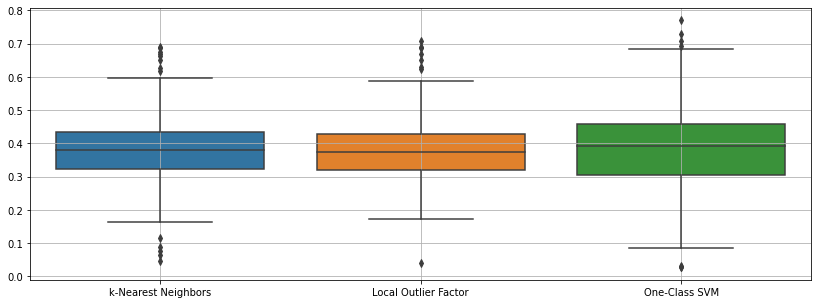

In [13]:
# Boxplots

dataframe = pd.DataFrame()
for estimator, performance in loaded_performances.items():
    df = pd.DataFrame({estimator: performance['remaining_life']})
    dataframe = pd.concat([dataframe, df])

plt.figure(figsize=(14, 5))
sns.boxplot(data=dataframe)
plt.grid()
plt.show()

In [ ]:
# Compute remaining useful life statistics

In [ ]:
# PCA

In [ ]:
# Optimize contamination

In [ ]:
# Create ensemble

In [ ]:
# Plot scores timeline

In [ ]:
# Create and compare baseline